# Exploring results for NAS with DMRL [V2]

## Global imports and variables

In [1]:
# Import for interactive notebook (see:
# https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

# Import to list files in directories
import glob

# Import for regular expressions
import re

# Imports for path operations
import os
import os.path

# For date operations
from datetime import datetime

import pandas as pd
pd.set_option('max_colwidth', -1)
import matplotlib.pyplot as plt

In [2]:
RESULTS_DIR = "/Users/gomerudo/workspace/thesis_results"

def rettext(text):
    return text

def search_in_file(file, pattern):
    pattern = re.compile(pattern)
    results = []
    for i, line in enumerate(open(file)):
        for match in re.finditer(pattern, line):
            results.append(match.groups())
    return results

form_item_layout = Layout(
    width="50%"
)

w_resdirs = interactive(
    rettext,
    text=sorted(glob.glob("{dir}/[0-9]*".format(dir=RESULTS_DIR))),
    layout=form_item_layout
)

## Selecting the desired results

In [3]:
display(w_resdirs)

interactive(children=(Dropdown(description='text', options=('/Users/gomerudo/workspace/thesis_results/26374', …

## Results

**Note**: In order to get the results, run all cells below once you have selected the desired directory in the cell above.

### Reading and parsing results

In [5]:
################################################################################
############ OBTAIN THE FILES AND DIRECTORIES TO QUERY FOR ANALYSIS ############
################################################################################

# Obtain the chosen directory
chosen_dir = w_resdirs.result

# experiments dir
exp_dir = glob.glob("{dir}/experiment*[!.zip]".format(dir=chosen_dir))[0]

# This is a list of all openai dirs, sorted by name (hence, by timestamp)
openai_dirs = sorted(glob.glob("{dir}/openai*[!.zip]".format(dir=exp_dir)))
if not len(openai_dirs):
    openai_dirs = sorted(glob.glob("{dir}/opeanai*[!.zip]".format(dir=exp_dir)))

# A simple DB of experiments and actions_info.csv should be there
dbexp_file = glob.glob("{dir}/db*".format(dir=exp_dir))[0]
ainfo_file = glob.glob("{dir}/act*".format(dir=exp_dir))[0]
#episode_logs = glob.glob("{dir}/episode_logs/*".format(dir=openai_dir))

flog_file = glob.glob("{dir}/sl*".format(dir=chosen_dir))[0]

# Make dataframes for the db of experiments and the actions summary
dbexp_df = pd.read_csv(dbexp_file)
ainfo_df = pd.read_csv(ainfo_file)

In [7]:
################################################################################
########### BUILD THE RELEVANT DATA FRAMES TO PRINT FOR MAIN SUMMARY ###########
################################################################################
    
# Try to obtain the current times
running_times = search_in_file(flog_file, ".*\s+(.*)elapsed")
if len(running_times) == len(openai_dirs):
    f_running_times = []
    for time in running_times:
        time_cleansed = time[0].split(".")[0]
        f_running_times.append(time_cleansed)
else:
    prev_timestamp = 0
    f_running_times = []
    for directory in openai_dirs:
        exp_dirname_only = os.path.basename(directory)
        timestamp = os.path.basename(exp_dirname_only.split("-")[1])
        d2 = datetime.strptime(timestamp, "%Y%m%d%H%M%S")
        if prev_timestamp:  # 2019 05 29 211533
            d1 = datetime.strptime(prev_timestamp, "%Y%m%d%H%M%S")
            f_running_times.append(str(d2 - d1))
        prev_timestamp = timestamp
    f_running_times.append("NA")
    
openai_dirs_df = pd.DataFrame(zip(openai_dirs, f_running_times), columns=["Log directory", "Runtime"])

# 4. Search all exceptions
exceptions_all = search_in_file(flog_file, "failed with exception of type.*<(.*)>.*Message.*:\s*(.*)")
n_exceptions = len(exceptions_all)

exceptions_set = set()
for error, message in exceptions_all:
    exceptions_set.add(error)

### Summary

#### Highglights

- **Chosen results directory is:** {{chosen_dir}}
- **Full log is available at:** {{flog_file}}
- **Total number of experiments in DB:** {{dbexp_df.shape[0]}}
- **Total number of actions considered:** {{ainfo_df.shape[0]}}
- **Total number of exceptions:** {{n_exceptions}}

#### Individual run directories/time

{{openai_dirs_df}}

### Errors found in log while building networks

{{pd.DataFrame(exceptions_set, columns = ["Error type"])}}

### The database of experiments

- **Full database available at:** {{dbexp_file}}
- **Total number of experiments in DB:** {{dbexp_df.shape[0]}}
- **Number of valid sampled architectures:** {{dbexp_df.loc[dbexp_df['is_valid'] == True].shape[0]}}
- **Number of non-valid sampled architectures:** {{dbexp_df.loc[dbexp_df['is_valid'] == False].shape[0]}}

#### The distribution of running times in the DB of experiments

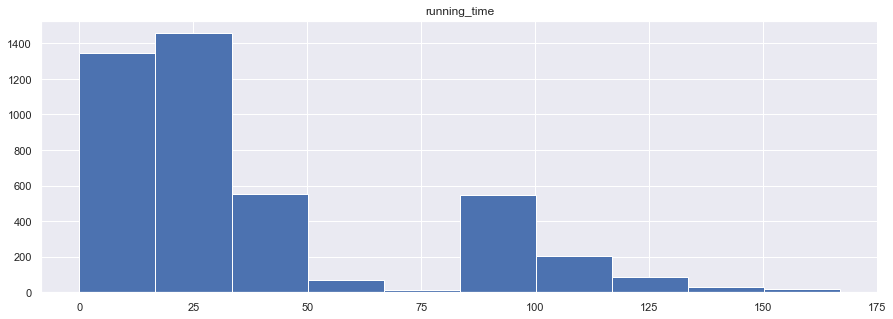

In [15]:
_ = dbexp_df.hist(column='running_time', figsize=(15, 5))

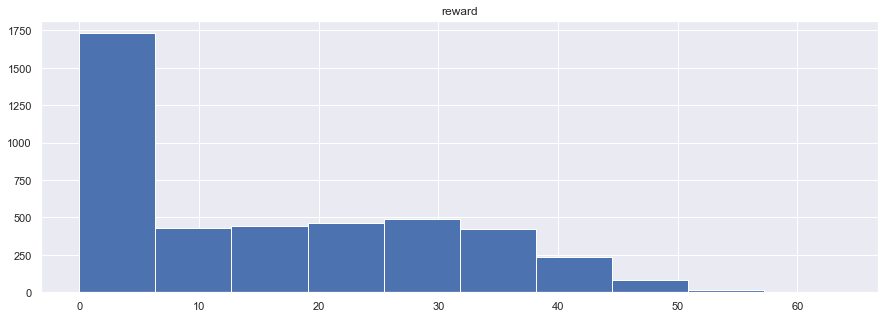

In [16]:
_ = dbexp_df.hist(column='reward', figsize=(15, 5))

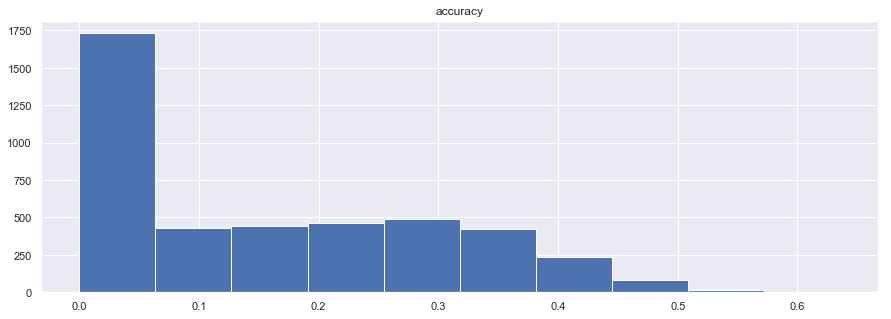

In [17]:
_ = dbexp_df.hist(column='accuracy', figsize=(15, 5))

#### Best reward

In [18]:
best_by_reward = dbexp_df.sort_values(by='reward', ascending=False)
best_arch_by_reward = best_by_reward.iloc[0]

**Main information**

- **ID:** {{best_arch_by_reward['dataset-nethash']}}
- **Index in DB:** {{best_arch_by_reward.name}}
- **Is valid?** {{best_arch_by_reward['is_valid']}}
- **Reward:** {{best_arch_by_reward['reward']}}
- **Accuracy:** {{best_arch_by_reward['accuracy']}}
- **Training time (in sec):** {{best_arch_by_reward['running_time']}}

**The architecture**

```{{for layer in best_arch_by_reward['netstring'].split("\n"):  print(layer)}}```

**Other information**

- **Timestamp:** {{best_arch_by_reward['timestamp']}}
- **Density:** {{best_arch_by_reward['density']}}
- **FLOPs:** {{best_arch_by_reward['flops']}}

#### Best accuracy

In [19]:
best_by_accuracy = dbexp_df.sort_values(by='accuracy', ascending=False)
best_arch_by_accuracy = best_by_accuracy.iloc[0]

**Main information**

- **ID:** {{best_arch_by_accuracy['dataset-nethash']}}
- **Index in DB:** {{best_arch_by_accuracy.name}}
- **Is valid?** {{best_arch_by_accuracy['is_valid']}}
- **Reward:** {{best_arch_by_accuracy['reward']}}
- **Accuracy:** {{best_arch_by_accuracy['accuracy']}}
- **Training time (in sec):** {{best_arch_by_accuracy['running_time']}}

**The architecture**

```{{for layer in best_arch_by_accuracy['netstring'].split("\n"):  print(layer)}}```

**Other information**

- **Timestamp:** {{best_arch_by_accuracy['timestamp']}}
- **Density:** {{best_arch_by_accuracy['density']}}
- **FLOPs:** {{best_arch_by_accuracy['flops']}}

### Analysis by trial

- **Total number of trials:** {{len(openai_dirs)}}

In [20]:
%matplotlib inline

def analyze_trial(trial_logs, trial_n):
    # We'll use this for the distribution of actions per trial
    actions_log = [0]*ainfo_df.shape[0]

    # This will store the max_step achieved per episode.
    max_step_count_history = []
    best_reward_history = []
    all_rewards_history = []
    step_in_ep = 0
    reward_in_ep = 0
    for log_file in trial_logs:
        try:
            ep_df = pd.read_csv("{f}".format(f=log_file))

            for idx, row in ep_df.iterrows():
                # 1. Add information to the distribution of actions
                action_id = int(row['action_id'])
                actions_log[action_id] += 1

                # 2. Keep the rewards
                c_reward = int(row['reward'])
                all_rewards_history.append(c_reward)
                
                # 3. Keep the best information and count episodes
                c_sc = int(row['step_count'])
                
                # 4. If we keep counting steps, accumulate information
                if c_sc > step_in_ep:
                    step_in_ep = c_sc
                    reward_in_ep = c_reward if c_reward > reward_in_ep else reward_in_ep
                # Otherwise, append the best information we read
                else:
                    max_step_count_history.append(step_in_ep)
                    best_reward_history.append(reward_in_ep)
                    step_in_ep = c_sc
                    reward_in_ep = 0
        except Exception as ex:
            pass

    return actions_log, max_step_count_history, best_reward_history, all_rewards_history


stats = []
for i, openai_dir in enumerate(openai_dirs):
    episode_logs = sorted(glob.glob("{dir}/episode_logs/*".format(dir=openai_dir)))
    actions_log, max_step_count_history, best_reward_history, all_rewards_history = analyze_trial(episode_logs, i+1)
    stats.append(
        {
            'actions_log': actions_log,
            'max_step_history': max_step_count_history,
            'best_reward_history': best_reward_history,
            'all_rewards_history': all_rewards_history
        }
    )


In [21]:
@interact
def trial_plots(trial=list(range(1, len(stats) + 1))):
    import seaborn as sns
    sns.set()
    
    fig, axes = plt.subplots(nrows = 2, ncols=2)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.8)
    
    fig.set_size_inches(16, 6)
    fig.suptitle(
        "Results for trial {t}\nNumber of episodes: {e}".format(
            t=trial,
            e=len(stats[trial-1]['best_reward_history'])
        ),
        va='bottom'
    )

    # Plot the actions distribution
    dact_ax = axes[0][0]
    dact_ax.set_title("Distribution of actions taken during trial")
    dact_ax.set_xlabel("Action ID")
    dact_ax.set_ylabel("Count")

    dact_ax.bar(
        range(len(stats[trial-1]['actions_log'])),
        stats[trial-1]['actions_log']
    )
    
    # Plot the max_step evolution
    maxsteps_ax = axes[0][1]
    maxsteps_ax.set_title("Evolution of max_step achieved through episodes")
    maxsteps_ax.set_xlabel("Episode")
    maxsteps_ax.set_ylabel("Max Step achieved")
    maxsteps_ax.plot(
        range(len(stats[trial-1]['max_step_history'])),
        stats[trial-1]['max_step_history']
    )

    # Plot the best reward evolution
    bestrew_ax = axes[1][0]
    bestrew_ax.set_title("Evolution of best reward through episodes")
    bestrew_ax.set_xlabel("Episode")
    bestrew_ax.set_ylabel("Reward")
    bestrew_ax.plot(
        range(len(stats[trial-1]['best_reward_history'])),
        stats[trial-1]['best_reward_history']
    )

    # Plot the histogram of rewards
    bestrew_ax = axes[1][1]
    bestrew_ax.set_title("Distribution of obtained rewards during trial")
    bestrew_ax.set_xlabel("Episode")
    bestrew_ax.set_ylabel("Count")
    bestrew_ax.hist(
        stats[trial-1]['all_rewards_history']
    )

interactive(children=(Dropdown(description='trial', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…